<a href="https://colab.research.google.com/github/TimothyQuill/TimothyQuill.github.io/blob/master/timothy_quill_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challenge Problem - Global Terrorist Attacks

### For this challenge I will be using the Global Terrorism Database (GTD) open-source database to build a model that can predict what group may have been responsible for an incident.

### Before I create the model I will begin by cleaning the data. I'll start by importing the Excel file into Python:

In [0]:
import numpy as np
import pandas as pd
import os
import datetime
import math

# get the path to the current working directory
cwd = os.getcwd()

# then add the name of the Excel file
file_path = "globalterrorismdb_0718dist.xlsx"

# Copy the database to file
df = pd.read_excel(file_path)

### Lets inspect the data:

In [0]:
# Print the number of rows in the data frame
print("Total rows: {0}".format(len(df)))

# View the first 3 rows of each column
print(df.loc[:3, :])

# View the column titles
print(list(df))

# find which columns have NaNs
print(df.columns[df.isna().any()].tolist())

Total rows: 181691
        eventid  iyear  imonth  iday approxdate  extended resolution  country  \
0  197000000001   1970       7     2        NaN         0        NaT       58   
1  197000000002   1970       0     0        NaN         0        NaT      130   
2  197001000001   1970       1     0        NaN         0        NaT      160   
3  197001000002   1970       1     0        NaN         0        NaT       78   

          country_txt  region   ...    addnotes scite1 scite2  scite3  \
0  Dominican Republic       2   ...         NaN    NaN    NaN     NaN   
1              Mexico       1   ...         NaN    NaN    NaN     NaN   
2         Philippines       5   ...         NaN    NaN    NaN     NaN   
3              Greece       8   ...         NaN    NaN    NaN     NaN   

   dbsource  INT_LOG  INT_IDEO INT_MISC INT_ANY  related  
0      PGIS        0         0        0       0      NaN  
1      PGIS        0         1        1       1      NaN  
2      PGIS       -9        -9  

### We'll remove the columns that aren't useful for our analysis:
###   -  all of the string-based columns that have a numerical equivalent can be cut, as they are redundant
###   -  'approxdate' isn't very useful because most rows are missing a values and the date is already provided in other columns
###   -  'summary' is expensive data-wise, and the information is repeated from whats available in other variables
###   -  none of the reference columns: ('scite1', 'scite2', 'scite3', 'dbsource') provide any useful info for our query
###   -  'addnotes', 'propcomment', 'related' and 'motive' have some valuable info, such as related attacks, however accessing it in a meaningful way will be difficult under the time constraint of this challenge, so it will be a secondary priority for now
###   -  'resolution' is redundant because 'nhours' provides the length of the incident in a more useful way

In [0]:
# store all of the _txt columns in a list for easy access
txt_columns = [s for s in list(df) if "_txt" in s]

# drop the unhelpful columns from the data frame
columns = [*txt_columns, 'approxdate', 'summary', 'addnotes', 'scite1', 'scite2', 'scite3', 'dbsource', 'weapdetail',
           'resolution', 'ransomnote', 'motive', 'propcomment', 'related']
df.drop(columns, inplace=True, axis=1)

# check that the dataframe has been updated correctly
print(list(df))

# also, the dataset is far too big for my computer to work with given the short amount of time to complete this
# challenge, so I will use a random subset of the data to work with:
df = df.sample(10000)
# and reset the index
df = df.reset_index(drop=True)
# Make sure the number of rows was reduced
print("Total rows: {0}".format(len(df)))

['eventid', 'iyear', 'imonth', 'iday', 'extended', 'country', 'region', 'provstate', 'city', 'latitude', 'longitude', 'specificity', 'vicinity', 'location', 'crit1', 'crit2', 'crit3', 'doubtterr', 'alternative', 'multiple', 'success', 'suicide', 'attacktype1', 'attacktype2', 'attacktype3', 'targtype1', 'targsubtype1', 'corp1', 'target1', 'natlty1', 'targtype2', 'targsubtype2', 'corp2', 'target2', 'natlty2', 'targtype3', 'targsubtype3', 'corp3', 'target3', 'natlty3', 'gname', 'gsubname', 'gname2', 'gsubname2', 'gname3', 'gsubname3', 'guncertain1', 'guncertain2', 'guncertain3', 'individual', 'nperps', 'nperpcap', 'claimed', 'claimmode', 'claim2', 'claimmode2', 'claim3', 'claimmode3', 'compclaim', 'weaptype1', 'weapsubtype1', 'weaptype2', 'weapsubtype2', 'weaptype3', 'weapsubtype3', 'weaptype4', 'weapsubtype4', 'nkill', 'nkillus', 'nkillter', 'nwound', 'nwoundus', 'nwoundte', 'property', 'propextent', 'propvalue', 'ishostkid', 'nhostkid', 'nhostkidus', 'nhours', 'ndays', 'divert', 'kidhij

### Now we'll do some cleaning. There are lots of missing values in the dataframe which is likely to effect our model. So we'll need to fill them. The missing data columns vary greatly:  some columns are metric whilst others are categorical, some rows are left intentionally blank e.g. values for most rows of 'attacktype2' are empty because a second attack didn't occur in most recordings, whilst others are blank due to a lack of information, e.g. 'location'. So we'll have to handle missing data on a column by column basis.

### Lets start with the 'eventid', which is the primary key for the dataset. Each value has to be unique, so we can just arbitrarily set any missing values to their index, as the official recorded numbers don't start until 197000000001, so there wont be any overlap:

In [0]:
df['eventid'] = [idx if math.isnan(x) else x for idx, x in enumerate(df['eventid'].tolist())]

### Now lets deal with the string-based categorical values. Firstly, the NaN values of the following categorical numerical columns will be replaced with 'None', which represents a valid category. It can be assumed from their large number of empty columns and their unlikelihood of occurring that the empty values are deliberate and signify that no instances of the value occurred:

In [0]:
columns = ['corp2', 'target2', 'corp3', 'target3', 'gsubname', 'gsubname2', 'gsubname3',
           'gname2', 'gname3', 'kidhijcountry', 'divert']
for col in columns:
    df[col].fillna('None', inplace=True)

# We'll leave the 'gname' Unknowns as is, cause it's going to be our dv:
df['gname'].fillna('Unknown', inplace=True)

### The small number of empty rows in the rest of the string-based categorical columns as well as their likelihood  (or certainty) of occurring suggest that the empty values are missing and signify that the correct data wasn't available, so they will be set to the mode, however they will be temporarily set to 999:

In [0]:
columns = ['location', 'corp1', 'target1', 'provstate', 'city', 'country', 'region', 'gname']
for col in columns:
    df[col].fillna(999, inplace=True)

### Next we need to convert the string-based categorical columns to a numerical index, so that they can be processed correctly by the model:

In [0]:
columns = ['provstate', 'city', 'location', 'corp1', 'target1', 'corp2', 'target2', 'corp3', 'target3', 'gname',
           'gsubname', 'gname2', 'gsubname2', 'gname3', 'gsubname3', 'kidhijcountry', 'divert', 'country', 'region']
for col in columns:
    df[col] = df[col].astype('category')
    df[col] = pd.factorize(df[col])[0]

### The NaN values of the following numerical columns will be replaced with 0, which represents a data-point for metric columns and a category for categorical ones. It can be assumed from their large number of empty columns and their unlikelihood of occurring that the empty values are deliberate and signify that no instances of the value occurred:

In [0]:
columns = ['attacktype2', 'attacktype3', 'targtype2', 'targsubtype2', 'natlty2', 'latitude', 'longitude',
           'targtype3', 'targsubtype3', 'natlty3', 'guncertain2', 'guncertain3', 'nhostkid', 'nhostkidus', 'nhours',
           'ndays', 'ransom', 'ransomamt', 'ransomamtus', 'ransompaid', 'ransompaidus', 'hostkidoutcome', 'nreleased',
           'extended', 'vicinity', 'crit1', 'crit2', 'crit3']
for col in columns:
    df[col].fillna(0, inplace=True)

### In the following numerical columns, the small number of empty rows as well as their likelihood (or certainty) of occurring suggest that the empty values are missing and signify that the correct data wasn't available, so they will be set to the mode:

In [0]:
columns = ['alternative', 'success', 'claimed', 'claim2', 'claim3', 'compclaim', 'claimmode', 'claimmode2', 'location',
           'claimmode3', 'weaptype1', 'weaptype2', 'weaptype3', 'weaptype4', 'weapsubtype1', 'weapsubtype2',
           'weapsubtype3','weapsubtype4', 'propextent', 'doubtterr', 'INT_LOG', 'INT_IDEO', 'INT_MISC', 'INT_ANY',
           'attacktype1', 'corp1', 'target1', 'provstate', 'city', 'country', 'region', 'multiple', 'suicide',
           'targsubtype1', 'natlty1', 'guncertain1', 'individual', 'property', 'ishostkid', 'targtype1']
for col in columns:
    # needed for any missing values set to '-99' (the pre-defined unknown value for the column)
    df[col] = [np.nan if (x < 0) or (x == 13 and (col == 'weaptype1' or col == 'weaptype2'
               or col == 'weaptype3' or col == 'weaptype4')) or (x == 4 and col == 'propextent')
               or (x == 8 and col == 'weapsubtype1') or (x == 999 and (col == 'location' or col == 'corp1'
               or col == 'target1' or col == 'provstate' or col == 'city' or col == 'country' or col == 'region'))
               else x for x in df[col].tolist()]
    # calculate the mode of the column
    column_temp = [0 if math.isnan(x) else x for x in df[col].tolist()]
    mode = max(set(column_temp), key=column_temp.count)
    # then apply the mode to all NaNs
    df[col].fillna(mode, inplace=True)

### The NaN values of the following discrete numerical columns will be replaced with the mean of the available values, which will allow all of the detail of the column to be kept. It can be assumed from the small number of empty rows as well as the likelihood of occurring that the correct data wasn't available:

In [0]:
columns = ['nkill', 'nkillus', 'nkillter', 'nwound', 'nwoundus', 'nwoundte', 'propvalue', 'nperps', 'nperpcap',
           'iyear', 'imonth', 'iday']
for col in columns:
    # needed for any missing values set to '-99'
    df[col] = [np.nan if (x < 0) else x for x in df[col].tolist()]
    # calculate the mean of the column
    column_temp = [0 if math.isnan(x) else x for x in df[col].tolist()]
    mean = round(np.mean(column_temp))
    # then apply the mean to all NaNs
    df[col].fillna(mean, inplace=True)

### Dates aren't useful in their current format, so they will be converted to an ordinal value of how many days have passed since the first recorded date in the data set:

In [0]:
# change all of the 0s to 1, as 0 can't be used as a valid date
columns = ['iday', 'imonth']
for col in columns:
    df[col] = [1 if int(x) == 0 else df[col].tolist()[idx]
               for idx, x in enumerate(df[col].tolist())]
# set the start_date to Jan, 1, 1970, which is the first recorded day in the data set
start_date = datetime.date(1970, 1, 1)
ndays = []
# calculate how many days have passed from the start date
for idx in range(len(df)):
    date_of_attack = datetime.date(df['iyear'][idx], df['imonth'][idx], df['iday'][idx])
    delta = date_of_attack - start_date
    ndays.append(delta.days)
# and store it in a new column in a dataframe called 'ndays'
df['ndays'] = ndays

### Finally, for all categorical variables, we need to convert them to one-shot encoding, so that our model can properly interpret them:

In [0]:
categorical = ['attacktype1', 'attacktype2', 'attacktype3', 'target1', 'target2', 'target3', 'targtype1', 'targtype2',
               'targtype3', 'targsubtype1', 'targsubtype2', 'targsubtype3', 'natlty1', 'natlty2', 'natlty3',
               'guncertain1', 'guncertain2', 'guncertain3', 'ransom', 'hostkidoutcome', 'ishostkid', 'extended',
               'vicinity', 'INT_LOG', 'INT_IDEO', 'INT_MISC', 'INT_ANY', 'propextent', 'crit1', 'crit2', 'crit3',
               'alternative', 'success', 'claimed', 'claim2', 'claim3', 'compclaim', 'claimmode', 'claimmode2',
               'claimmode3', 'location', 'provstate', 'city', 'country', 'region', 'weaptype1', 'weaptype2',
               'weaptype3', 'weaptype4', 'weapsubtype1', 'weapsubtype2', 'weapsubtype3','weapsubtype4', 'doubtterr',
               'corp1', 'corp2', 'corp3', 'multiple', 'suicide', 'gsubname', 'gsubname2', 'gsubname3', 'individual',
               'property']

# Get one hot encoding for all categorical column
one_hot = pd.get_dummies(data=df, columns=categorical)
# Then join the one hot df to our dataframe
df = pd.concat([df, one_hot], axis=1)
for cat in categorical:
    # Then drop the columns cause they're now encoded
    df.drop(cat, inplace=True, axis=1)

# Remove duplicate columns that were added from the join
columns = list(df.columns)
for idx, col in enumerate(df.columns):
    if col in df.columns[:idx]: columns[idx] = "to_drop"
df.columns = columns
df = df.drop("to_drop", 1)

## Now it's time to make the model. As the goal of this challenge is to analyse variables to predict a DV ('gname'), I considered several classification models - such as logistic regression and NN - that could be suitable. Ultimately I opted to use a random forest for several reasons:

## 1. Random forests can handle classification problems, which is needed cause my DV is a category
## 2. They're highly effective, and don't suffer from overfitting, like simpler decision tree models
## 3. They can handle missing values, of which my dataset has many
## 4. Given the limited amount of time I felt more confident about being able to produce a reasonably effective model. Unlike a neural network, which could require a lot of adjusting and extensive processing time
## 5. Finally, a random forest intuitively seemed like a good fit for this dataset, as I could visualise how the variables could be easily split across branches to form a prediction.

### So lets get started on the model. We'll begin by importing the sklearn, matplotlib and seaborn packages, the former to create the RF and the others to create charts:

In [0]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import accuracy_score

### Next seperate the dataframe into its x and y variables, and then seperate it again into training and test sets, producing four sets:

In [0]:
y = df.loc[:, 'gname']
df.drop('gname', inplace=True, axis=1)
x = df
# 70% training data, 30% test data
# Split dataset into training set and test set
training_x, test_x, training_y, test_y = train_test_split(x, y, test_size=0.3)

### I created a classifier, adjusting the parameters to get the best result. I chose 128 trees, which is as many as I can use on my machine before it crashes, and is a good balance between predictive accuracy and computational economy. I played around with the other paramenters, and got the best results with these values:

In [0]:
classifier = RandomForestClassifier(n_estimators=128, max_features=0.2, min_samples_leaf=60, oob_score=True)

### Train the model using the training data

In [0]:
classifier.fit(training_x, training_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=60, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=128, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

### We can pass in the independent variables of the test set to form a prediction about our dependent variable:

In [0]:
predict_y = classifier.predict(test_x)

### We can view all of the predictions for the test set:

In [0]:
print("Predictions: ", predict_y)

Predictions:  [ 0  0 14 ... 24 13  0]


### The metrics.accuracy_score function shows how often our model is correct:

In [0]:
print("Accuracy: ", accuracy_score(test_y, predict_y))

Accuracy:  0.591


### Create a series containing all of the feature importance scores:

In [0]:
feature_imp = pd.Series(classifier.feature_importances_, index=df.columns).sort_values(ascending=False)
print(feature_imp[:10, ])

INT_IDEO_1.0       0.071073
INT_IDEO_0.0       0.068251
longitude          0.065658
latitude           0.062452
ndays              0.047114
guncertain1_0.0    0.043923
claimed_1.0        0.043311
guncertain1_1.0    0.039443
claimed_0.0        0.037589
eventid            0.035680
dtype: float64


### There's a big drop-off after the first ten or so columns, so let's create a graph just focussing on them:

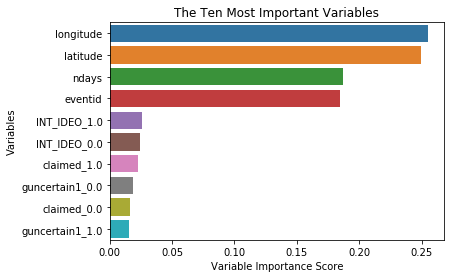

In [0]:
# Creating a bar plot showing top 10 most important features
sns.barplot(x=feature_imp[:10, ], y=feature_imp.index[:10, ])
# Create labels for the graph
plt.xlabel('Variable Importance Score')
plt.ylabel('Variables')
plt.title('The Ten Most Important Variables')
plt.show()

### Lets remove all of the non-important features, which may help improve the performance of our good ones:

In [0]:
unimportant_features = list(feature_imp.index[10:, ])
# Now drop them from the dataframe and run the model again:
df.drop(unimportant_features, inplace=True, axis=1)

# Make sure 'gname' isn't removed
df['gname'] = y

### Then rerun the above code train the model and test it again:

Accuracy:  0.6943333333333334
longitude          0.255489
latitude           0.249419
ndays              0.186652
eventid            0.184552
INT_IDEO_1.0       0.025978
INT_IDEO_0.0       0.024584
claimed_1.0        0.022858
guncertain1_0.0    0.018936
claimed_0.0        0.016170
guncertain1_1.0    0.015363
dtype: float64


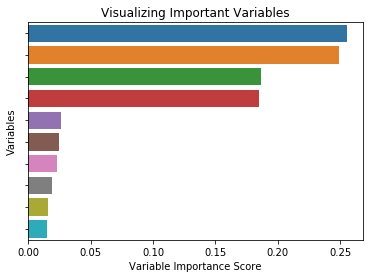

In [0]:
y = df.loc[:, 'gname']
df.drop('gname', inplace=True, axis=1)
x = df
# 70% training data, 30% test data
# Split dataset into training set and test set
training_x, test_x, training_y, test_y = train_test_split(x, y, test_size=0.3)

classifier = RandomForestClassifier(n_estimators=128)

classifier.fit(training_x, training_y)

predict_y = classifier.predict(test_x)

print("Accuracy: ", accuracy_score(test_y, predict_y))

feature_imp = pd.Series(classifier.feature_importances_, index=df.columns).sort_values(ascending=False)
print(feature_imp)

barplot = sns.barplot(x=feature_imp, y=feature_imp.index)
barplot.set(yticklabels=[])
# Create labels for the graph
plt.xlabel('Variable Importance Score')
plt.ylabel('Variables')
plt.title('Visualizing Important Variables')
plt.show()

### After removing the unimportant rows the model's accuracy increased from 0.591 to 0.6943, which is a marked improvement, and is all I could complete given the limited scope of the challenge.